In [1]:
import numpy as np
import matplotlib.pyplot as plt

The classes in the first sections will normally be in a package. I placed them here, so you can see what is happening under the hood.

## Stochastic integration classes

In [2]:
class reactionIntegrator:
    '''
    Parent (abstract) class for all reaction integrators
    '''

    def __init__(self, dt=0.0001, stride=1, tfinal=1000):
        # Define default simulation parameters
        self.setSimulationParameters(dt, stride, tfinal)

    def setSimulationParameters(self, dt, stride, tfinal):
        '''
        Function to set simulation parameters. This will be inherited
        and used by child classes
        '''
        self.dt = dt
        self.stride = stride
        self.tfinal = tfinal
        if self.dt == 0:
            # In case of no fixed timestepping, like Gillespie, these variables are useless
            self.timesteps  = 0
        else:
            self.timesteps = int(self.tfinal/self.dt)

    def integrateOne(self, reactionModel):
        '''
        'Abstract' method used to integrate one time step or iteration of the
        current algorithm
        '''
        raise NotImplementedError("Please Implement integrateOne method")

    def propagate(self, reactionModel):
        '''
        'Abstract' method used to integrate propagate the algorithm up to
        tfinal.
        '''
        raise NotImplementedError("Please Implement propagate method")

In [3]:
class gillespie(reactionIntegrator):
    '''
    Integrator class to integrate a well-mixed reaction model using the gillespie or SSA algorithm
    '''

    def __init__(self, stride, tfinal):
        # inherit all methods from parent class
        super().__init__(0, stride, tfinal)

    def integrateOne(self, reactionModel, returnReactionIndex=False):
        '''
        One iteration of the Gillespie algorithm. Outputs lagtime and
        final value of copy numbers after iteration
        '''
        r1 = np.random.rand()
        r2 = np.random.rand()
        lambda0 = np.sum(reactionModel.propensities)
        ratescumsum = np.cumsum(reactionModel.propensities)
        # Gillespie, time and transition (reaction index)
        lagtime = np.log(1.0 / r1) / lambda0
        reactionIndex = int(sum(r2 * lambda0 > ratescumsum))
        deltaX = reactionModel.reactionVectors[reactionIndex]
        nextX = reactionModel.X + deltaX
        if returnReactionIndex:
            return lagtime, nextX, reactionIndex
        else:
            return lagtime, nextX

    def propagate(self, reactionModel):
        '''
        Integrate reaction model until tfinal using the Gillespie and
        outputs full trajetory Xtraj
        '''
        percentage_resolution = self.tfinal / 100.0
        time_for_percentage = - 1 * percentage_resolution
        # Begins Gillespie algorithm
        t = 0.0
        Xtraj = [reactionModel.X]
        times = [t]
        while t <= self.tfinal:
            lagtime, nextX = self.integrateOne(reactionModel)
            # Update variables
            Xtraj.append(nextX)
            reactionModel.X = nextX
            reactionModel.updatePropensities()
            t += lagtime
            times.append(times[-1] + lagtime)
            # Print integration percentage
            if (t - time_for_percentage >= percentage_resolution):
                time_for_percentage = 1 * t
                print("Percentage complete ", round(100 * t / self.tfinal, 1), "%           ", end="\r")
        print("Percentage complete 100%       ", end="\r")
        return times, np.array(Xtraj)

## Reaction models classes

In [4]:
class reactionModel:
    '''
    Parent (abstract) class for all reaction models
    '''

    def populateReactionVectors(self):
        '''
        'Abstract' method needed to populates reaction vectors
        of a given reaction system. Each reaction vectors correspond to
        the copy number change of all the species involved
        for the corresponding reaction. Note this will need a reaction vectors
        variablev (reactionVectors) of dimension corresponding to the number
        of reactions times the number of chemical species involved.
        '''
        raise NotImplementedError("Please Implement populateReactionVectors method")

    def updatePropensities(self):
        '''
        'Abstract' method to update the propensities, since propensities
        depend on the copy number of the chemical species, they need to be
        updated every time the number of chemical species changes. The method
        can be made more efficient by only updating the propensities that
        changed. Note this will require a propensities variable (propensities)
        of dimension corresponding to the number of all possible reactions.
        '''
        raise NotImplementedError("Please Implement updatePropensities method")

In [5]:
class basicCooperation(reactionModel):
    
    def __init__(self, C, D, Gc, Gd):
        # inherit all methods from parent class
        super().__init__()

        # Define default initial conditions and names
        self.X = np.array([C, D, Gc, Gd]) 
        self.names = ['cooperatos', 'defectors', 'gain_cooperating', 'gain_defecting']
        
        # Initialize reaction vectors (stochiometry) and propensities
        self.nreactions = 3
        self.reactionVectors = np.zeros([self.nreactions, len(self.X)])
        self.propensities = np.zeros(self.nreactions)

        # Define default paramters, based on ODE model and data generation parameters 
        # (Prisoners' dilemma: tau=1 > r > p > s=0 )
        tau, r, p, s = 1, 0.8, 0.2, 0
        k1, k2, k3 = 1.0, 1.0, 1.0
        self.volume = 1.0
        self.setModelParameters(tau, r, p, s, k1, k2, k3, volume)
        
    def setModelParameters(self, tau, r, p, s, k1, k2, k3, volume):
        self.tau = tau
        self.r = r
        self.p = p
        self.s = s
        self.k1 = k1
        self.k2 = k2
        self.k3 = k3
        self.volume = volume
        self.populateReactionVectors()
        self.updatePropensities()


    def populateReactionVectors(self):
        self.reactionVectors[0] = [0, 0, 2*self.r, 0]       # C + C -k1-> C + C + 2r G_c
        self.reactionVectors[1] = [0, 0, self.s, self.tau]  # C + D -k1-> C + D + s G_c + tau G_d
        self.reactionVectors[2] = [0, 0, 0, 2*self.p]       # D + D -k3-> D + D + 2p G_d

    def updatePropensities(self):
        C, D, Gc, Gd = self.X
        self.propensities[0] = self.k1 * C * (C-1)/self.volume
        self.propensities[1] = self.k2 * C * D/ (self.volume)
        self.propensities[2] = self.k3 * D * (D-1)/self.volume

## Sample script to run model (prisioners' dilemma)

In [6]:
# Initial conditions
C, D, Gc, Gd = 5, 5, 0, 0

# Create integrator 
stride = 1
tfinal = 10
integratorGillespie = gillespie(stride,tfinal)


# Create reaction model (prisioners' dilemma)
tau, r, p, s = 1, 0.8, 0.2, 0.0
k1, k2, k3 = 1.0, 1.0, 1.0
volume = 1.0
prisionersDilemma = basicCooperation(C, D, Gc, Gd)
prisionersDilemma.setModelParameters(tau, r, p, s, k1, k2, k3, volume)

In [7]:
# Run one simulation
times, traj = integratorGillespie.propagate(prisionersDilemma)

In [8]:
#Extract data
trajarray = np.array(traj)
C = trajarray[:,0]
D = trajarray[:,1]
Gc = trajarray[:,2]
Gd = trajarray[:,3]

Text(0, 0.5, 'Gain')

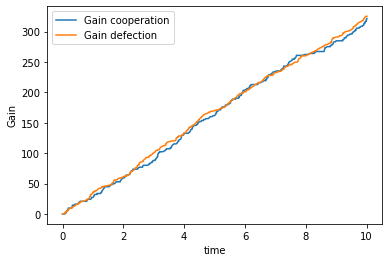

In [9]:
# Plot data
plt.plot(times, Gc, label = 'Gain cooperation')
plt.plot(times, Gd, label = 'Gain defection')
plt.legend()
plt.xlabel('time')
plt.ylabel('Gain')

## Prisioners' dilemma (Comparison between different inital conditions)

In [10]:
# Three models with different initial conditions (default parameters set to prisioners dilemma)
prisionersDilemma1 = basicCooperation(3, 7, 0, 0)
prisionersDilemma2 = basicCooperation(5, 5, 0, 0)
prisionersDilemma3 = basicCooperation(7, 3, 0, 0)
# Save ICs for plotting later
initialConditions = [prisionersDilemma1.X[0:2], prisionersDilemma2.X[0:2], prisionersDilemma3.X[0:2]]

In [11]:
timesPD1, trajPD1 = integratorGillespie.propagate(prisionersDilemma1)
timesPD2, trajPD2 = integratorGillespie.propagate(prisionersDilemma2)
timesPD3, trajPD3 = integratorGillespie.propagate(prisionersDilemma3)

In [12]:
#Extract data
GcPD1 = trajPD1[:,2]
GdPD1 = trajPD1[:,3]
GcPD2 = trajPD2[:,2]
GdPD2 = trajPD2[:,3]
GcPD3 = trajPD3[:,2]
GdPD3 = trajPD3[:,3]

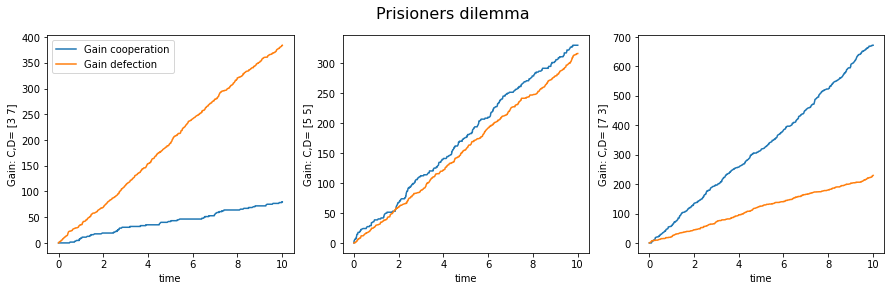

In [18]:
# Plot data for different intial conditions
fig, ax = plt.subplots(1,3, figsize = (15,4))
fig.suptitle('Prisioners dilemma', fontsize=16)
ax[0].plot(timesPD1, GcPD1, label = 'Gain cooperation')
ax[0].plot(timesPD1, GdPD1, label = 'Gain defection')
ax[1].plot(timesPD2, GcPD2)
ax[1].plot(timesPD2, GdPD2)
ax[2].plot(timesPD3, GcPD3)
ax[2].plot(timesPD3, GdPD3)
ax[0].legend()
for i in range(3):
    ax[i].set_ylabel('Gain: C,D= ' + np.array2string(initialConditions[i]))
    ax[i].set_xlabel('time')

## Stag Hunt

In [14]:
# Create integrator 
stride = 1
tfinal = 10
integratorGillespie = gillespie(stride,tfinal)

# Create reaction model (prisioners' dilemma)
r, tau, p, s = 1, 0.7, 0.4, 0.0
k1, k2, k3 = 1.0, 1.0, 1.0
volume = 1.0
stagHunt1 = basicCooperation(3, 7, 0, 0)
stagHunt2 = basicCooperation(5, 5, 0, 0)
stagHunt3 = basicCooperation(7, 3, 0, 0)
stagHunt1.setModelParameters(tau, r, p, s, k1, k2, k3, volume)
stagHunt2.setModelParameters(tau, r, p, s, k1, k2, k3, volume)
stagHunt3.setModelParameters(tau, r, p, s, k1, k2, k3, volume)

In [15]:
# Run simulations
timesSH1, trajSH1 = integratorGillespie.propagate(stagHunt1)
timesSH2, trajSH2 = integratorGillespie.propagate(stagHunt2)
timesSH3, trajSH3 = integratorGillespie.propagate(stagHunt3)

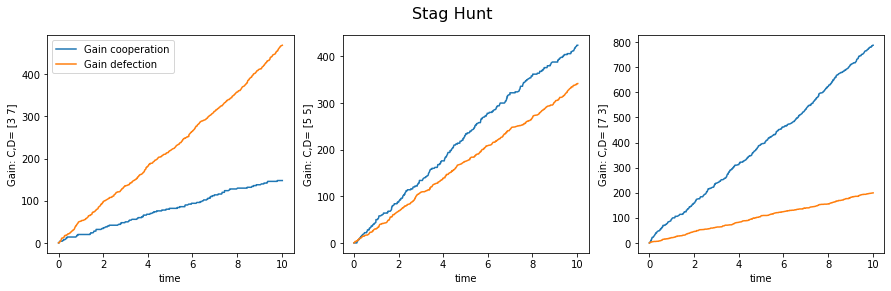

In [17]:
# Plot data for different intial conditions (skipped extract data, not required)
fig, ax = plt.subplots(1,3, figsize = (15,4))
fig.suptitle('Stag Hunt', fontsize=16)
ax[0].plot(timesSH1, trajSH1[:,2], label = 'Gain cooperation')
ax[0].plot(timesSH1, trajSH1[:,3], label = 'Gain defection')
ax[1].plot(timesSH2, trajSH2[:,2])
ax[1].plot(timesSH2, trajSH2[:,3])
ax[2].plot(timesSH3, trajSH3[:,2])
ax[2].plot(timesSH3, trajSH3[:,3])
ax[0].legend()
for i in range(3):
    ax[i].set_ylabel('Gain: C,D= ' + np.array2string(initialConditions[i]))
    ax[i].set_xlabel('time')